In [2]:
import cv2
import json
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from __future__ import unicode_literals
from sklearn.model_selection import train_test_split

In [17]:
# blow out the bbox into max.min values
def expand_bbox_coords(bbox):
    xmin = bbox[0]
    ymin = bbox[1]
    xmax = bbox[0] + bbox[2]
    ymax = bbox[1] + bbox[3]

    return (xmin, ymin, xmax, ymax)


def obtain_bbox_label(categories, bbox_tag):
    
    label = categories[categories['id']==bbox_tag['category_id']]['name'].item()
    label = str(label)

    return (label)


def coco_to_dict(img, annots_df):

    # obtain relevant image data
    img_name = os.path.basename(img['file_name'])
    img_size = (img['width'], img['height'], 3)
    
    # cut to relevant bbox annotations
    img_id = img['id']
    tags = annots_df[annots_df['image_id']==img_id]

    # iterate through bbox annotations
    bboxes = []
    for _, tag in tags.iterrows():
        bbox_annot = {
            'label': tag['category_id'],
            'xmin': tag['xmin'],
            'ymin': tag['ymin'],
            'xmax': tag['xmax'],
            'ymax': tag['ymax']
        }
        bboxes.append(bbox_annot)
       
    img_dict = {
        'bboxes': bboxes,
        'image_name': img_name,
        'image_size': img_size
    }
    
    return img_dict


def dict_to_yolo(img_dict):
    img_name = img_dict['image_name']
    img_width, img_height, img_depth = img_dict['image_size']

    annot_txt =[]
    for box in img_dict['bboxes']:

        # extract abs bbox info
        lbl = box['label']
        x_centre = (box['xmin'] + box['xmax']) / 2
        y_centre = (box['ymin'] + box['ymax']) / 2
        width = box['xmax'] - box['xmin']
        height = box['ymax'] - box['ymin']

        # convert bbx infor to rel
        x_centre = round(x_centre / img_width, 3)
        y_centre = round(y_centre / img_height, 3)
        width = round(width / img_width, 3)
        height = round(height / img_height, 3)

        annot_txt.append(" ".join([
            str(lbl), str(x_centre), str(y_centre), str(width), str(height)
            ]))

    annot_name = os.path.splitext(img_name)[0] + '.txt'
        

    return annot_name, annot_txt



def copy_files(list_img, list_annot, split, output_base):

    # copy the images over
    img_folder = os.path.join(output_base, 'images', split)
    if not os.path.isdir(img_folder):
        os.makedirs(img_folder)

    for x in list_img:
        shutil.copy(x, img_folder)

    # copy the annotation files over
    annot_folder = os.path.join(output_base, 'labels', split)
    if not os.path.isdir(annot_folder):
        os.makedirs(annot_folder)

    for x in list_annot:
        shutil.copy(x, annot_folder)
    
    return 


def display_image(img_file, dim = (20,6)):

    # load, inverting colour array to align with OpenCV behaviour
    img = cv2.imread(img_file)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # display using matplotlib
    plt.figure(figsize = dim)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    return

### Annotating Images

The first step is to obtain a dataset of suitably annotated images on which to train the model. For the purpose of object detection it is important to ensure that the annotation data is fine-grained - contains class label and coordinate location of associated bboxes. 

While there are various open source datasets containing annotated logo data for some of the biggest brands, in order to show how this could be applied to a specific use case, I chose to manually label a specific brand using the free labelling software "Label Studio"

The brand I selected was Petronas which are major sponsors of Mercedes F1 team - with the outputs of my manual labelling found in "data/Label_Studio_Output". 

It is worth noting that Label Studio enables annotation data to be exported into various different formats - e.g. Pascal VOC, COCO, CSV, COCO - if you are not familair with the different formats I recommend the following aritcle: https://www.edge-ai-vision.com/2022/04/exploring-data-labeling-and-the-6-different-types-of-image-annotation/

In order to export a single  file containing details off all images' annotations i opted for COCO json format, but more on that in a little bit.

In [3]:
# load the annotation set
data = json.load(open('data/Label_Studio_Output_2/result.json'))

# convert annotated images json to dataframe to make slicing easier
images = pd.DataFrame(data['images'])

# convert annotated labels json to dataframe to make slicing easier
annots = pd.DataFrame(data['annotations'])
annots[['xmin', 'ymin', 'xmax', 'ymax']] = annots.apply(lambda x: expand_bbox_coords(x['bbox']), axis=1, result_type='expand')

# convert annotated images json to dataframe to make slicing easier
labels = pd.DataFrame(data['categories'])

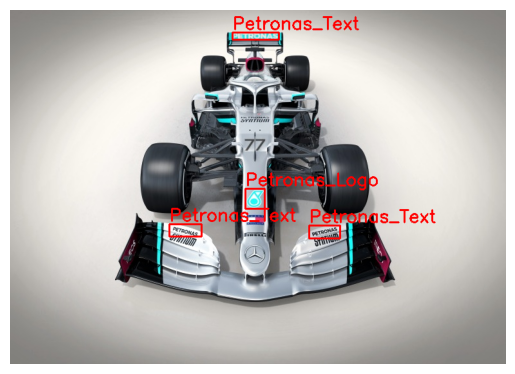

In [30]:
# print a test annotation
img_id = 49

# take the entry for the relevant image id
test_img = images[images['id']==img_id]

# load image
path = f"data/Label_Studio_Output_2/images/{os.path.basename(test_img['file_name'][img_id])}"
image = cv2.imread(path)

# ensure we are using the correct colour spectrum when displaying
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

# overlay relevant bounding boxes
relevant_annots = annots[annots['image_id']==img_id]
for index, tag in relevant_annots.iterrows():
    # display bbox
    cv2.rectangle(
            image, 
            (int(tag.xmin), int(tag.ymin)), (int(tag.xmax), int(tag.ymax)),
            (255, 0, 0), 2
        )
    
    # display text label
    text = obtain_bbox_label(labels, tag)
    cv2.putText(
        image, text, (int(tag.xmin), int(tag.ymin-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, 
        (255,0,0), 2
        )

# display
plt.imshow(image)
plt.axis('off')
plt.show()

### Convert Annotation Format

It is worth noting that, while the COCO json format I chose for my Label Studio export is convenient as it ensures all annotation data is contained in a single file, it is not the correct format for training the YOLO model architecture. Before we can begin to think about training the YOLO model, we need to first convert the COCO json format annotations to suitable YOLO format text files.

This repository backs use of an erlier project where I trained a YOLOv5 model, using a dataset of just 50 images: https://github.com/totogot/Logo_Detection. The annotated data from this project has been copied into this repo in the "Label_Studio_Output_1" folder.

However, for the purpose of this project, in order to test out training YOLOv7 I decided to tag an additional 50 images - found in "Label_Studio_Output_2". Therefore, the task is to covert this second batch of data to the appropriate format,and then combine into a single dataset.

In [32]:
# define output dir (creating it if doesnt exist)
output_folder = 'data/Label_Studio_Output_2/yolo_annotations'
if not os.path.isdir(output_folder):
    os.makedirs(output_folder)

# convert COCO to Yolo format
for _, image in images.iterrows():

    # extract COCO annotations to Yolo format
    image_dict = coco_to_dict(image, annots)
    file_name, file_txt = dict_to_yolo(image_dict)

    # save the file
    with open(os.path.join(output_folder, file_name), 'w') as f:
        for entry in file_txt:
            f.write(f"{entry}\n")

### Prepare Dataset

Now we have the correct format, we need to split the 50 images in to train, validate, and test sets. We will then copy these out to new relevant folders in preparation for training our model

In [42]:
# combine the two datasets into one
base_path_1 = 'data/Label_Studio_Output_1/'
base_path_2 = 'data/Label_Studio_Output_2/'

image_list_1 = [os.path.join(base_path_1, 'images', x) for x in os.listdir(os.path.join(base_path_1, 'images'))]
image_list_2 = [os.path.join(base_path_2, 'images', x) for x in os.listdir(os.path.join(base_path_2, 'images'))]
image_list = image_list_1 + image_list_2 

annot_list_1 = [os.path.join(base_path_1, 'yolo_annotations', x) for x in os.listdir(os.path.join(base_path_1, 'yolo_annotations'))]
annot_list_2 = [os.path.join(base_path_2, 'yolo_annotations', x) for x in os.listdir(os.path.join(base_path_2, 'yolo_annotations'))]
annot_list = annot_list_1 + annot_list_2

# to be sure the files are in the same order we sort
image_list.sort()
annot_list.sort()

# confirm there are no duplicates in naming convention - from joining the two sets
assert(len(image_list) == len(set(image_list)))
assert(len(annot_list) == len(set(annot_list)))


# obtain the train and test 
img_train, img_test, annot_train, annot_test = train_test_split(image_list, annot_list, test_size = 0.1, random_state = 1)
img_val, img_test, annot_val, annot_test = train_test_split(img_test, annot_test, test_size = 0.5, random_state = 1)

In [44]:
copy_files(img_train, annot_train, 'train', 'data/petronas_logo_detection')
copy_files(img_val, annot_val, 'val', 'data/petronas_logo_detection')
copy_files(img_test, annot_test, 'test', 'data/petronas_logo_detection')

### Download Relevant Yolo

In [2]:
!git clone https://github.com/WongKinYiu/yolov7.git

Cloning into 'yolov7'...


Now we need to ensure we install the YOLOv7 requirements.

However, first we make sure to comment out lines 11, 12 & 34 in the requirements file ("./yolov7/requirements.txt"). This is because we will install CUDA enabled torch seperately, and because we already have ipython kernel installed.

After having commented out these lines we can proceed with installing the required packages:

In [ ]:
!pip install -r ./yolov7/requirements.txt

Now we need to install CUDA enabled torch to enable training on a GPU. To do so, check the official Pytorch website to get the command for installing the version of Pytorch with GPU enabled: https://pytorch.org/get-started/locally/

Be sure to select the correct version of CUDA compatibility for your specific CUDA version. In my case the command was as follows:

In [5]:
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116
     ---------------------------------------- 2.4/2.4 GB 470.2 kB/s eta 0:00:00
     ---------------------------------------- 4.8/4.8 MB 9.3 MB/s eta 0:00:00
     ---------------------------------------- 2.3/2.3 MB 9.1 MB/s eta 0:00:00
  Using cached typing_extensions-4.4.0-py3-none-any.whl (26 kB)
  Using cached requests-2.28.1-py3-none-any.whl (62 kB)
  Using cached certifi-2022.12.7-py3-none-any.whl (155 kB)
  Using cached urllib3-1.26.13-py2.py3-none-any.whl (140 kB)
  Using cached charset_normalizer-2.1.1-py3-none-any.whl (39 kB)
  Using cached idna-3.4-py3-none-any.whl (61 kB)


In [1]:
# check we have correctly installed CUDA enabled Pytorch
import torch
torch.cuda.is_available()

c:\Users\fergu\Documents\PersonalProjects\Logo_Detection_YOLOv7\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

### Training

Now that we have our data in the correct format and folder structure, we need to prepare for training our YOLO model. This involves creating yaml files to specify the labels we wish our model to learn, as well as deciding on the model architecture, size and parameters: 

1) Create a new yaml file in the folder "yolov7/data/", which specifies the detection task at hand. In the case of this project I created a file called "petronas_logo.yaml" (for future repeatability, I have also included this in the repo under "./data/YOLOv7_Configs/petronas_logo.yaml"). The file itself is populated with the following: 
```
    train: ./data/petronas_logo_detection/images/train/
    val: ./data/petronas_logo_detection/images/val/ 
    test: ./data/petronas_logo_detection/images/test/

    # number of classes
    nc: 2

    # class names
    names: ['Petronas_Logo', 'Petronas_Text']
```


2) Next we need to decide on the model architecture we wish to use. Several standard model architecture yaml files have been in "yolov5/cfg/training/". These specify the architecture relating to the models outlined in Wong Kin Yiu's repo: https://github.com/WongKinYiu/yolov7#performance. Given that I intend to run the training locally, and therefore want to limit the computational resources required, I opted for the "tiny" model architecture, file "yolov7/cfg/training/yolov7.yaml".

    Now I need to create a copy of the file (which I chose to rename "yolov7-tiny-petronas.yaml") and change line 2 to read "nc: 2" - reflecting the fact I only plan to train the model to predict 2 labels.


3) Lastly to improve performance, and avoid the need to train the model from scratch, we will leverage transfer learning to train our logo detection model. For this we will load the pre-trained weights obtained through the initial training of the model on the 2017 COCO dataset (as outlined by the model developers, in their paper: https://arxiv.org/abs/2207.02696). This allows us to utilise the various filter layers the model has learned, for identifying key features such as the outline of objects, and then fine tune the final predictive layer for our specific task.

    To do so we can download the pretrained model weights to our project repo - I will do using the "curl" package to ensure repeatability

In [3]:
!curl -L https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-tiny.pt --output ./yolov7/data/yolov7-tiny.pt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 26 12.0M   26 3231k    0     0  2355k      0  0:00:05  0:00:01  0:00:04 3202k
100 12.0M  100 12.0M    0     0  6214k      0  0:00:01  0:00:01 --:--:-- 7605k


### Training the YOLOv7 model

We are now all set to train our model. We will do this by executing a CLI command (which I chose to execute directly from the notebook, as follows):

In [ ]:
!python yolov7/train.py --data yolov7/data/petronas_logo.yaml --img 640 640 --cfg yolov7/cfg/training/yolov7-tiny-petronas.yaml --weights yolov7/data/yolov7-tiny.pt --hyp yolov7/data/hyp.scratch.tiny.yaml --name yolov7-petronas --workers 1 --device 0 --batch-size 16 --epochs 200

In the above command I set the batch size to 16 given the limited memory of my GPU chip (4GB). Depending on the size of GPU memory available to you, you may wish to increase the batch size to improve the in-batch learning rate. If you are similarly running into memory errors, as I did, you can check the overall memory usage while the training is in progress, but executing the following command in the CLI:
```
nvidia-smi -l 1
```

Note: on initial run, I was faced with errors around "RuntimeError: indices should be either on cpu or on the same device as the indexed tensor (cpu)". To address this, I referred to the top answer provided on StackOveflow here: https://stackoverflow.com/questions/74372636/indices-should-be-either-on-cpu-or-on-the-same-device-as-the-indexed-tensor

Which stated:

```
"I believe it's a bug in the current implementation. You can fix it by changing utils/loss.py line 685 to:
    from_which_layer.append((torch.ones(size=(len(b),)) * i).to('cuda'))

and also add a line after 756 to put fg_mask_inboxes on your cuda device:
    fg_mask_inboxes = fg_mask_inboxes.to(torch.device('cuda'))"
```

The issue appears to revolve around the CUDA integration in the version of the YOLOv7 repo published. Making the suggested edits above addressed the problem, and enabled me to train my model using the GPU available to me.

### Analysing the training results

Now we have trained our model we can look at the outputted results files to assess the accuracy of our model


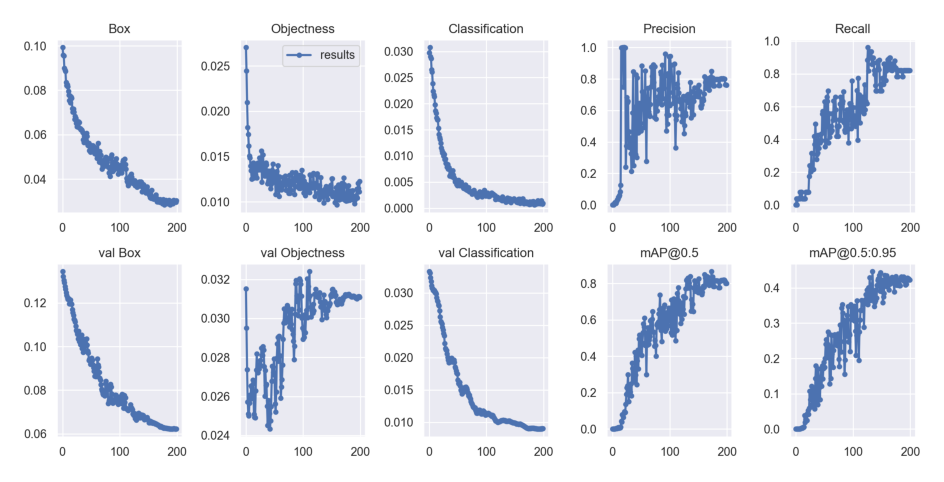

In [18]:
# display the results ouput
display_image('runs/train/yolov7-petronas/results.png')

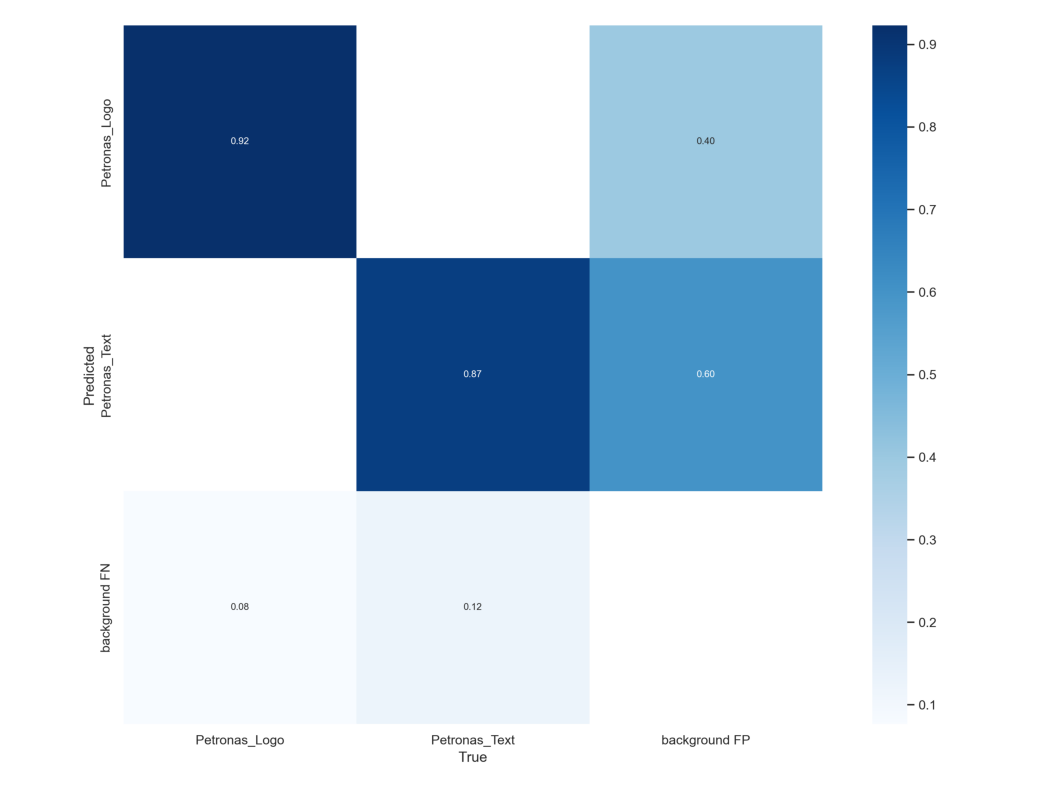

In [23]:
# display the confusion matrix ouput
display_image('runs/train/yolov7-petronas/confusion_matrix.png', dim = (20,10))

### Running inference on a single image

After training the model, you will have two different set of weights outputted - "last.pt" and "best.pt". Where these will be found will depend on where you executed the train command from (i.e. repo base directory, or within the cloned YOLOv7 folder), in my case these are "./runs/train/yolov7-petronas"

We can now run inference using the "best.pt" weights

In [10]:
!python yolov7/detect.py --weights runs/train/yolov7-petronas/weights/best.pt --conf 0.35 --img-size 640 --source data/petronas_logo_detection/images/test/eb413099-petronas_40.jpg --name yolov7_example

Namespace(weights=['runs/train/yolov7-petronas/weights/best.pt'], source='data/petronas_logo_detection/images/test/eb413099-petronas_40.jpg', img_size=640, conf_thres=0.35, iou_thres=0.45, device='', view_img=False, save_txt=False, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='yolov7_example', exist_ok=False, no_trace=False)
Fusing layers... 
IDetect.fuse
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

4 Petronas_Logos, 1 Petronas_Text, Done. (16.0ms) Inference, (0.0ms) NMS
 The image with the result is saved in: runs\detect\yolov7_example\eb413099-petronas_40.jpg
Done. (0.148s)


YOLOR  v0.1-116-g8c0bf3f torch 1.13.1+cu116 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4095.5625MB)

c:\Users\fergu\Documents\PersonalProjects\Logo_Detection_YOLOv7\venv\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 208 layers, 6010302 parameters, 0 gradients, 13.0 GFLOPS


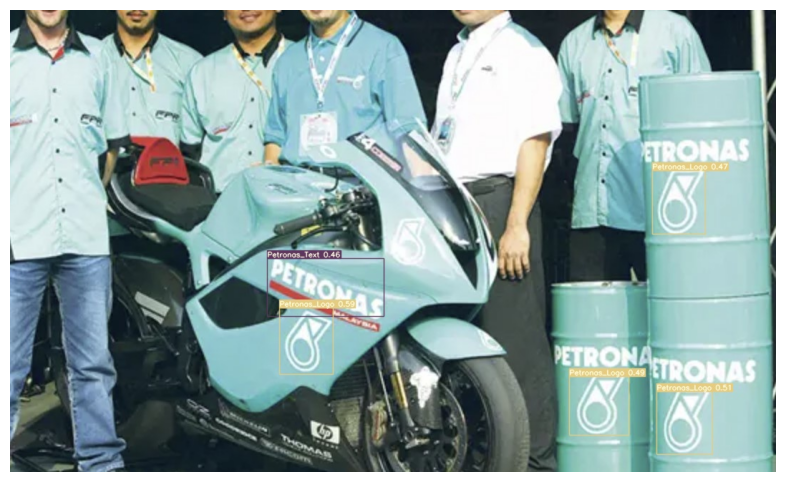

In [24]:
# display the annotated image
display_image('runs\detect\yolov7_example\eb413099-petronas_40.jpg')

From the above example, we see that the logo itself gets detected with c.80% confidence in all cases, while the text is not well recognised. 

This likely stems from the task on which the YOLO model I used for transfer learning was not trained to detect text specifically. This means that the various layers are not configured to identify letters of text, but instead individual objects 

### Running inference on a folder of images

We can also run inference on a complete folder at a time

In [26]:
!python yolov7/detect.py --weights runs/train/yolov7-petronas/weights/best.pt --conf-thres 0.35 --img-size 640 --source data/inference_images/ --name folder_example --save-txt

Namespace(weights=['runs/train/yolov7-petronas/weights/best.pt'], source='data/inference_images/', img_size=640, conf_thres=0.35, iou_thres=0.45, device='', view_img=False, save_txt=True, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='folder_example', exist_ok=False, no_trace=False)
Fusing layers... 
IDetect.fuse
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

2 Petronas_Logos, 1 Petronas_Text, Done. (37.4ms) Inference, (45.1ms) NMS
 The image with the result is saved in: runs\detect\folder_example\petronas_test1.jpg
4 Petronas_Logos, 1 Petronas_Text, Done. (7.0ms) Inference, (2.0ms) NMS
 The image with the result is saved in: runs\detect\folder_example\petronas_test2.jpg
1 Petronas_Logo, 1 Petronas_Text, Done. (9.2ms) Inference, (2.0ms) NMS
 The image with the result is saved in: runs\detect\folder_example\petronas_test3.jpg
4 Petronas_Logos, 2 Petronas_Texts, Done. (7.0ms)

YOLOR  v0.1-116-g8c0bf3f torch 1.13.1+cu116 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4095.5625MB)

c:\Users\fergu\Documents\PersonalProjects\Logo_Detection_YOLOv7\venv\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 208 layers, 6010302 parameters, 0 gradients, 13.0 GFLOPS


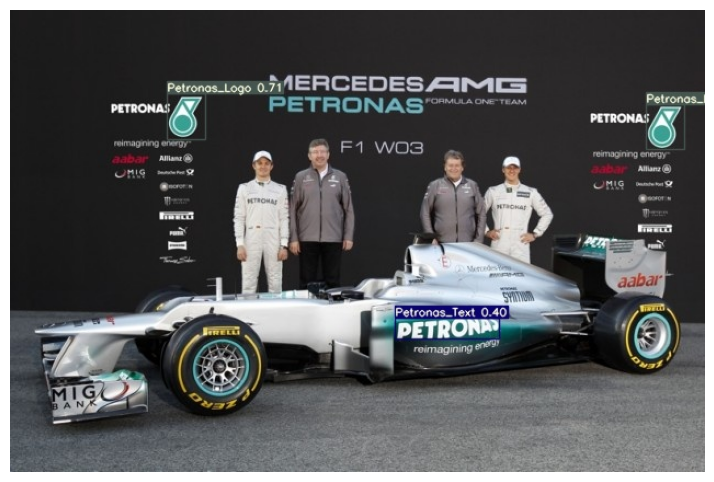

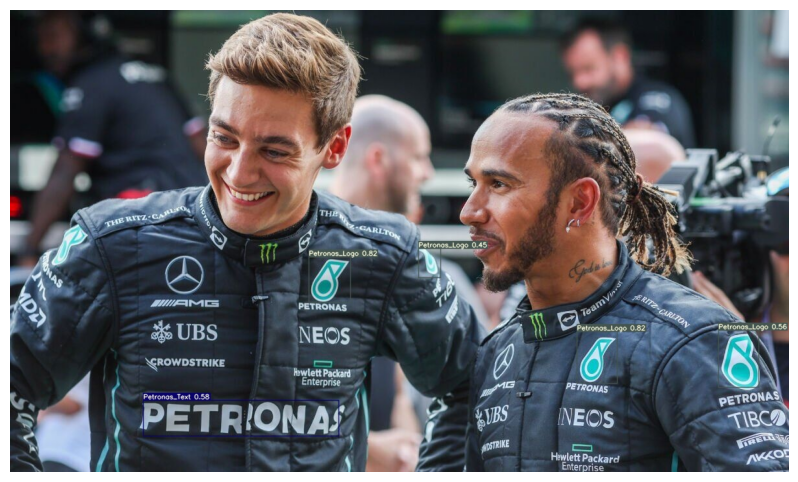

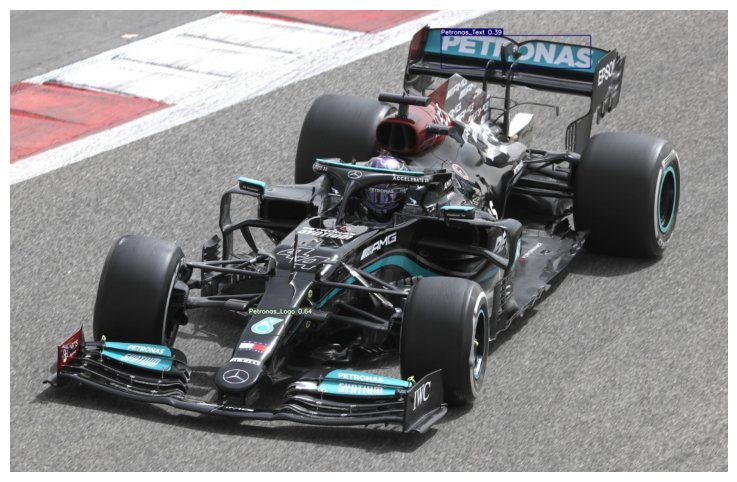

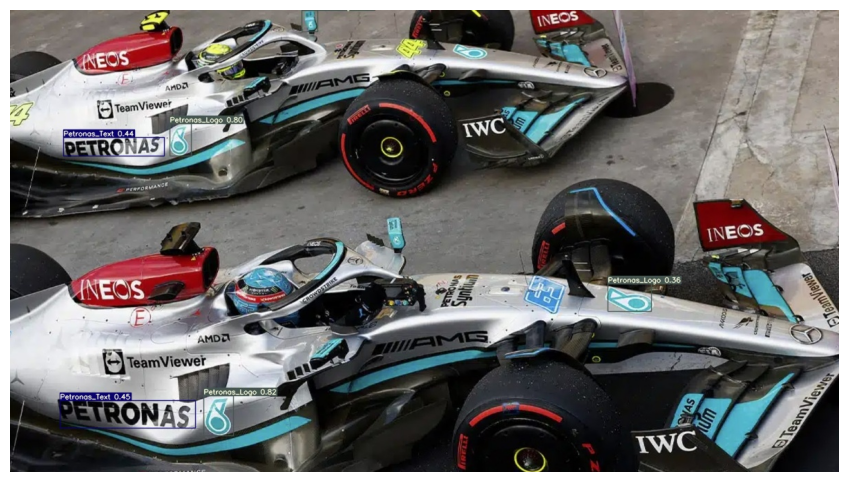

In [33]:
img_list = [os.path.join('runs/detect/folder_example/', x) for x in os.listdir('runs/detect/folder_example/') if x.endswith(".jpg")]

for img in img_list:
    display_image(img)

### Closing Comments

From the results files above we can see that on the whole both precision, recall, and mAP tend towards c.80% as the epochs increase. Overall this is not bad given the very limited size of our training data. Looking at the confusion matrix, we can see that the overall accuracy for the Logo prediction tends to be better than that of the Text.

This is largely supported by the pattern we see in the above examples, whereby there are several instances of the "Petronas" text appearing but not being detected by the model. On initial reflrection, this is likely due to the pretrained layers of our model being trained on the COCO dataset, so being more geared towards identifying the outline of objects as opposed to blocks of text.

It goes without saying but increasing the volume of training data, the size ofthe models, and parameters such as batch size would most likely increase accuracy, if you are looking to deploy a custom trained model into a production environment.